<a href="https://colab.research.google.com/github/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/

In [2]:
cd Remaining-Useful-Life-Estimation-Variational/

[WinError 2] The system cannot find the file specified: 'Remaining-Useful-Life-Estimation-Variational/'
d:\College\iit kharagpur\SEMINAR\CMAPSSData


In [17]:
import utils
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Bidirectional, Masking

# Data

In [18]:
dataset = "FD001"
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_val, y_val, x_test, y_test = utils.get_data(dataset, sensors, sequence_length, alpha, threshold)

FileNotFoundError: [Errno 2] No such file or directory: './data/train_FD001.txt'

# Model

In [8]:
# Setup the network parameters:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10
# used to mask values in sequences with less than 30 cycles until 30 is reached
masking_value = -99.

NameError: name 'x_train' is not defined

In [4]:
class Sampling(keras.layers.Layer):
  """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon

In [5]:
# ----------------------- Encoder -----------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding
h = Bidirectional(LSTM(intermediate_dim))(mask) 

# VAE Z layer
mu = Dense(latent_dim)(h)
sigma = Dense(latent_dim)(h)

z = Sampling()([mu, sigma])

# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
print(encoder.summary())
# -------------------------------------------------------

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 30, 5)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 600)          734400      masking[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            1202        bidirectional[0][0]              
____________________________________________________________________________________________

In [6]:
# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')
reg_intermediate = Dense(200, activation='tanh')(reg_latent_inputs)
reg_outputs = Dense(1, name='reg_output')(reg_intermediate)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------

Model: "regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling_reg (InputLayer)  [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               600       
_________________________________________________________________
reg_output (Dense)           (None, 1)                 201       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# ----------------------- Decoder --------------------
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h_decoded = RepeatVector(timesteps)(latent_inputs)
h_decoded = Bidirectional(LSTM(intermediate_dim, return_sequences=True))(h_decoded) 
# decoded layer
outputs = LSTM(input_dim, return_sequences=True)(h_decoded) 

# Instantiate the decoder model:
decoder = keras.Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())
# -------------------------------------------------------

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 2)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 600)           727200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 5)             12120     
Total params: 739,320
Trainable params: 739,320
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
class RVE(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(RVE, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
          self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        

    @property
    def metrics(self):
      if self.decoder!=None:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
            self.reconstruction_loss_tracker
        ]
      else:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
        ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
              reconstruction = self.decoder(z)
              reconstruction_loss = tf.reduce_mean(
                  keras.losses.mse(x, reconstruction)
              )
              total_loss = kl_loss + reg_loss + reconstruction_loss
              self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
              total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              keras.losses.mse(x, reconstruction)
          )

          total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
          total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }

Epoch 1/5
139/139 [==============================] - 44s 318ms/step - loss: 9718.0670 - kl_loss: 0.0086 - reg_loss: 9690.6777
Epoch 2/5
139/139 [==============================] - 40s 286ms/step - loss: 9623.7264 - kl_loss: 28.4613 - reg_loss: 9503.1895
Epoch 3/5
139/139 [==============================] - 44s 319ms/step - loss: 8464.7759 - kl_loss: 166.3813 - reg_loss: 7518.8672
Epoch 4/5
139/139 [==============================] - 49s 353ms/step - loss: 4223.2216 - kl_loss: 127.5350 - reg_loss: 2884.9729
Epoch 5/5
139/139 [==============================] - 52s 371ms/step - loss: 899.7211 - kl_loss: 103.3767 - reg_loss: 830.8750


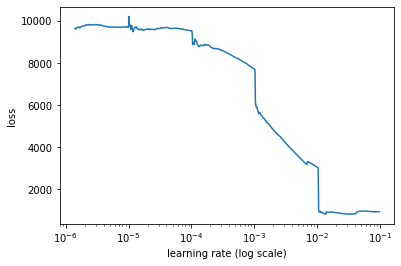

In [10]:
rve = RVE(encoder, regressor)
lr_finder = utils.LRFinder(rve)

rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000001))

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0000001 to 1
lr_finder.find(x_train, y_train, start_lr=0.000001, end_lr=0.1, batch_size=batch_size, epochs=5)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
rve.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size)

Epoch 1/10
139/139 [==============================] - 17s 59ms/step - loss: 4203.1811 - kl_loss: 88.2411 - reg_loss: 3394.7080 - val_loss: 56.1885 - val_kl_loss: 4.0807 - val_reg_loss: 52.1078
Epoch 2/10
139/139 [==============================] - 6s 40ms/step - loss: 1984.2021 - kl_loss: 45.6486 - reg_loss: 1629.6056 - val_loss: 71.6071 - val_kl_loss: 4.1091 - val_reg_loss: 67.4980
Epoch 3/10
139/139 [==============================] - 5s 39ms/step - loss: 999.5434 - kl_loss: 30.9614 - reg_loss: 823.6000 - val_loss: 27.4602 - val_kl_loss: 5.1143 - val_reg_loss: 22.3459
Epoch 4/10
139/139 [==============================] - 6s 41ms/step - loss: 546.8593 - kl_loss: 22.7195 - reg_loss: 458.2628 - val_loss: 86.8812 - val_kl_loss: 5.9517 - val_reg_loss: 80.9295
Epoch 5/10
139/139 [==============================] - 6s 41ms/step - loss: 341.5001 - kl_loss: 17.7728 - reg_loss: 301.1023 - val_loss: 90.4341 - val_kl_loss: 6.0053 - val_reg_loss: 84.4288
Epoch 6/10
139/139 [=========================

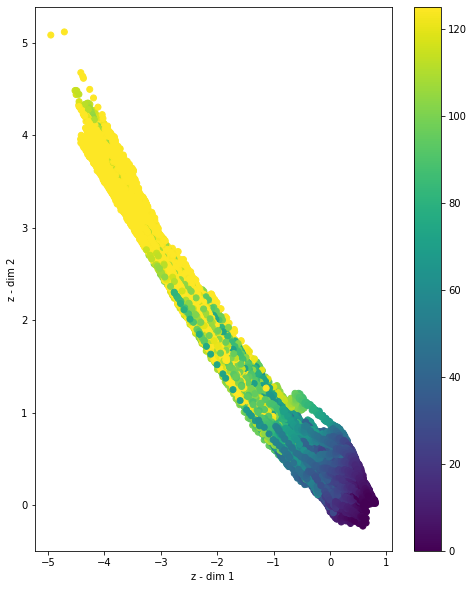

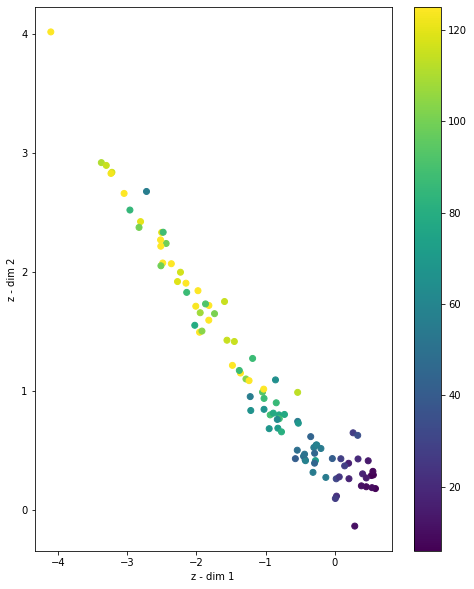

train set RMSE:12.24322509765625, R2:0.9127130765750903
test set RMSE:17.401550074510553, R2:0.8232875997283737


In [ ]:
train_mu = utils.viz_latent_space(rve.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = utils.viz_latent_space(rve.encoder, x_test, y_test.clip(upper=threshold))
# Evaluate
y_hat_train = rve.regressor.predict(train_mu)
y_hat_test = rve.regressor.predict(test_mu)

utils.evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
utils.evaluate(y_test, y_hat_test, 'test')